In [2]:
import pandas as pd
import backtrader as bt
import matplotlib
import datetime
from datetime import datetime, timedelta
#%matplotlib inline

In [61]:
file_path = 'D:\\SierraChart\\Data\\ESM24_FUT_CME [CBV][M]  1500 Volume #4_GraphData.txt'
df = pd.read_csv(file_path, delimiter=',')


AttributeError: 'RangeIndex' object has no attribute 'date'

In [62]:
df.head()

,Date,Time,Open,High,Low,Last,Volume,NumTrades,OHLC Avg,HLC Avg,...,Line1,Line2,Line3,Line4,Line5,Line6,Line7,Line8,Line9,TR
0,2024-5-1,18:00:00.000000,5057.00,5060.00,5056.50,5057.69,1500,1070,5057.80,5058.06,...,2500,-2500,5000,-5000,20000,-20000,0,10000,-10000,1.0
1,2024-5-1,18:01:34.718000,5057.34,5059.75,5056.25,5058.06,1500,1057,5057.85,5058.02,...,2500,-2500,5000,-5000,20000,-20000,0,10000,-10000,1.0
2,2024-5-1,18:05:31.034000,5057.70,5062.00,5057.70,5060.06,1500,1139,5059.37,5059.92,...,2500,-2500,5000,-5000,20000,-20000,0,10000,-10000,1.0
3,2024-5-1,18:09:41.725013,5058.88,5060.25,5057.75,5059.56,1500,1006,5059.11,5059.19,...,2500,-2500,5000,-5000,20000,-20000,0,10000,-10000,1.0
4,2024-5-1,18:16:29.471009,5059.22,5060.50,5058.00,5059.44,1500,955,5059.29,5059.31,...,2500,-2500,5000,-5000,20000,-20000,0,10000,-10000,1.0


In [63]:
df.columns = df.columns.str.strip()

In [64]:
df = df.rename(columns={'Last': 'Close'})

In [65]:
df.columns

Index(['Date', 'Time', 'Open', 'High', 'Low', 'Close', 'Volume', 'NumTrades',
       'OHLC Avg', 'HLC Avg', 'HL Avg', 'Bid Vol', 'Ask Vol', 'ECIVwap',
       'Top Band 2 of Vwap Standard Deviation',
       'Bottom Band 2 of Vwap Standard Deviation',
       'Top Band 3 of Vwap Standard Deviation',
       'Bottom Band 3 of Vwap Standard Deviation', 'Vwap extension',
       'Top band 2 extension', 'Bottom band 2 extension', 'Point of Control',
       'Value Area High Value', 'Value Area Low Value',
       'Volume Weighted Average Price', 'High.1', 'Low.1', 'High.2', 'Low.2',
       'Line1', 'Line2', 'Line3', 'Line4', 'Line5', 'Line6', 'Line7', 'Line8',
       'Line9', 'TR'],
      dtype='object')

In [66]:
class CustomPandasData(bt.feeds.PandasData):
    lines = ('vwap', 'top_band_2', 'bottom_band_2', 'top_band_3', 'bottom_band_3')
    params = (
        ('vwap', -1),
        ('top_band_2', -1),
        ('bottom_band_2', -1),
        ('top_band_3', -1),
        ('bottom_band_3', -1),
        ('mult', 50),
    )

In [67]:

df['datetime'] = pd.to_datetime(df['Date'].str.strip() + ' ' + df['Time'].str.strip())
df.set_index('datetime', inplace=True)


In [68]:
selected_date = '2024-05-31'
df2 = df[df.index.date == pd.to_datetime(selected_date).date()]


In [69]:
data = CustomPandasData(
    dataname=df2,
    mult=50,
    open='Open',
    high='High',
    low='Low',
    close='close',
    volume='Volume',
    vwap='Volume Weighted Average Price',
    top_band_2='Top Band 2 of Vwap Standard Deviation',
    bottom_band_2='Bottom Band 2 of Vwap Standard Deviation',
    top_band_3='Top Band 3 of Vwap Standard Deviation',
    bottom_band_3='Bottom Band 3 of Vwap Standard Deviation'
)

In [70]:
cerebro = bt.Cerebro()
cerebro.adddata(data)
cerebro.broker.set_cash(10000)
cerebro.broker.setcommission(commission=0.0)
cerebro.addstrategy(BandBounceStrategy916)
cerebro.run()


BUY: 2024-05-31 09:01:00.340006
BUY EXECUTED: 5268.82
CLOSE LONG: 2024-05-31 09:02:41.207001
SELL EXECUTED: 5268.13
TRADE PROFIT, GROSS: -0.6899999999995998, NET: -0.6899999999995998
BUY: 2024-05-31 09:03:44.425004
Order Canceled/Margin/Rejected
Order Canceled/Margin/Rejected
BUY: 2024-05-31 09:05:10.427002
BUY EXECUTED: 5267.05
CLOSE LONG: 2024-05-31 09:06:31.019011
SELL EXECUTED: 5266.65
TRADE PROFIT, GROSS: -0.4000000000005457, NET: -0.4000000000005457
BUY: 2024-05-31 09:08:00.914027
Order Canceled/Margin/Rejected
Order Canceled/Margin/Rejected
BUY: 2024-05-31 09:09:23.585003
BUY EXECUTED: 5266.43
CLOSE LONG: 2024-05-31 09:11:02.420003
SELL EXECUTED: 5266.56
TRADE PROFIT, GROSS: 0.13000000000010914, NET: 0.13000000000010914
BUY: 2024-05-31 09:12:20.322005
Order Canceled/Margin/Rejected
Order Canceled/Margin/Rejected
BUY: 2024-05-31 09:13:57.326005
BUY EXECUTED: 5267.98
CLOSE LONG: 2024-05-31 09:15:16.182005
SELL EXECUTED: 5268.21
TRADE PROFIT, GROSS: 0.23000000000047294, NET: 0.2300

Final Portfolio Value: 10000.00


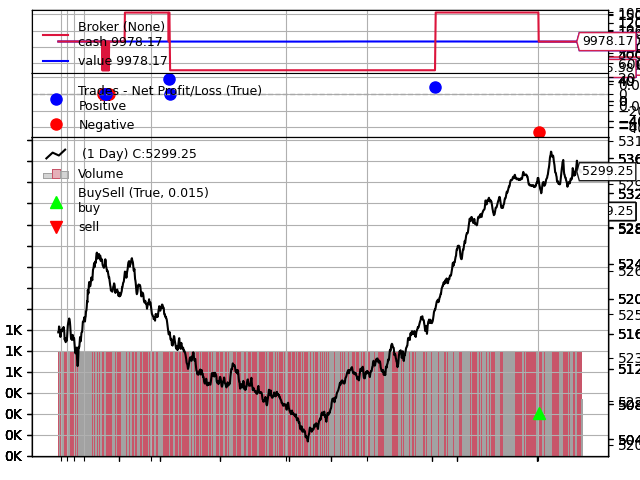

[[<Figure size 1600x1200 with 20 Axes>]]

In [71]:
#%matplotlib widget
cerebro.plot(iplot=False)

In [53]:
class SimpleStrategy(bt.Strategy):
    def next(self):
        print(f"Close price: {self.data.close[0]}")

cerebro.addstrategy(SimpleStrategy)

1

In [50]:
class TestStrat(bt.Strategy):
    params = (
        ('size', 1),  # Liczba kontraktów
    )

    def __init__(self):
        self.data_close = self.datas[0].close
        self.order = None

    def next(self):
        print(f"Processing bar: {len(self)}")
        if self.order:
            return

        if not self.position:
            if self.data_close > self.data.vwap:
                self.buy()
        else:
            if self.data_close < self.data.vwap:
                self.sell()

    def buy(self):
        price = self.data_close[0]
        size = self.params.size
        cash = self.broker.getcash()
        value = price * size * self.data.params.mult
        if cash >= value:
            self.order = self.buy(size=size)

    def sell(self):
        self.order = self.sell(size=self.params.size)

    def notify_order(self, order):
        if order.status in [order.Completed]:
            if order.isbuy():
                print(f'Buy executed at {order.executed.price:.2f}')
            else:
                print(f'Sell executed at {order.executed.price:.2f}')

            self.bar_executed = len(self)

        self.order = None

    def notify_trade(self, trade):
        if trade.isclosed:
            print(f'Trade P/L: {trade.pnl:.2f}')

In [12]:
class BandBounceStrategy(bt.Strategy):
    def __init__(self):
        self.dataclose = self.datas[0].close
        self.top_band_2 = self.datas[0].top_band_2
        self.bottom_band_2 = self.datas[0].bottom_band_2

    def next(self):
        # Sprawdź, czy mamy otwartą pozycję
        if self.position:
            # Zamknięcie pozycji short na dolnej bandzie
            if self.position.size < 0 and self.dataclose[0] <= self.bottom_band_2[0]:
                self.close()
                print(f'CLOSE SHORT: {self.datas[0].datetime.date(0)}')
            # Zamknięcie pozycji long na górnej bandzie
            elif self.position.size > 0 and self.dataclose[0] >= self.top_band_2[0]:
                self.close()
                print(f'CLOSE LONG: {self.datas[0].datetime.date(0)}')
        else:
            # Long, jeśli świeczka otworzyła się i zamknęła powyżej górnej bandy
            if self.datas[0].open[0] > self.top_band_2[0] and self.dataclose[0] > self.top_band_2[0]:
                self.buy()
                print(f'BUY: {self.datas[0].datetime.date(0)}')
            # Short, jeśli świeczka otworzyła się poniżej górnej bandy i zamknęła powyżej
            elif self.datas[0].open[0] < self.top_band_2[0] and self.dataclose[0] > self.top_band_2[0]:
                self.sell()
                print(f'SELL: {self.datas[0].datetime.date(0)}')
            # Long, jeśli świeczka otworzyła się i zamknęła poniżej dolnej bandy
            elif self.datas[0].open[0] < self.bottom_band_2[0] and self.dataclose[0] < self.bottom_band_2[0]:
                self.buy()
                print(f'BUY: {self.datas[0].datetime.date(0)}')
            # Short, jeśli świeczka otworzyła się powyżej dolnej bandy i zamknęła poniżej
            elif self.datas[0].open[0] > self.bottom_band_2[0] and self.dataclose[0] < self.bottom_band_2[0]:
                self.sell()
                print(f'SELL: {self.datas[0].datetime.date(0)}')

In [16]:
class BandBounceStrategy(bt.Strategy):
    params = (
        ('stop_loss', 0.02),  # Stop loss w procentach
        ('take_profit', 0.04),  # Take profit w procentach
    )

    def __init__(self):
        self.dataclose = self.datas[0].close
        self.top_band_2 = self.datas[0].top_band_2
        self.bottom_band_2 = self.datas[0].bottom_band_2
        self.order = None

    def next(self):
        # Sprawdź, czy mamy otwartą pozycję
        if self.position:
            # Zamknięcie pozycji short na dolnej bandzie
            if self.position.size < 0 and self.dataclose[0] <= self.bottom_band_2[0]:
                self.close()
                print(f'CLOSE SHORT: {self.datas[0].datetime.date(0)}')
            # Zamknięcie pozycji long na górnej bandzie
            elif self.position.size > 0 and self.dataclose[0] >= self.top_band_2[0]:
                self.close()
                print(f'CLOSE LONG: {self.datas[0].datetime.date(0)}')
        else:
            # Long, jeśli świeczka otworzyła się i zamknęła powyżej górnej bandy
            if self.datas[0].open[0] > self.top_band_2[0] and self.dataclose[0] > self.top_band_2[0]:
                self.order = self.buy()
                print(f'BUY: {self.datas[0].datetime.date(0)}')
            # Short, jeśli świeczka otworzyła się poniżej górnej bandy i zamknęła powyżej
            elif self.datas[0].open[0] < self.top_band_2[0] and self.dataclose[0] > self.top_band_2[0]:
                self.order = self.sell()
                print(f'SELL: {self.datas[0].datetime.date(0)}')
            # Long, jeśli świeczka otworzyła się i zamknęła poniżej dolnej bandy
            elif self.datas[0].open[0] < self.bottom_band_2[0] and self.dataclose[0] < self.bottom_band_2[0]:
                self.order = self.buy()
                print(f'BUY: {self.datas[0].datetime.date(0)}')
            # Short, jeśli świeczka otworzyła się powyżej dolnej bandy i zamknęła poniżej
            elif self.datas[0].open[0] > self.bottom_band_2[0] and self.dataclose[0] < self.bottom_band_2[0]:
                self.order = self.sell()
                print(f'SELL: {self.datas[0].datetime.date(0)}')

    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            return

        if order.status in [order.Completed]:
            if order.isbuy():
                print(f'BUY EXECUTED: {order.executed.price}')
                self.sl_order = self.sell(
                    exectype=bt.Order.Stop,
                    price=order.executed.price * (1.0 - self.params.stop_loss)
                )
                self.tp_order = self.sell(
                    exectype=bt.Order.Limit,
                    price=order.executed.price * (1.0 + self.params.take_profit)
                )
            elif order.issell():
                print(f'SELL EXECUTED: {order.executed.price}')
                self.sl_order = self.buy(
                    exectype=bt.Order.Stop,
                    price=order.executed.price * (1.0 + self.params.stop_loss)
                )
                self.tp_order = self.buy(
                    exectype=bt.Order.Limit,
                    price=order.executed.price * (1.0 - self.params.take_profit)
                )
        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            print('Order Canceled/Margin/Rejected')
        self.order = None

    def notify_trade(self, trade):
        if not trade.isclosed:
            return
        print(f'TRADE PROFIT, GROSS: {trade.pnl}, NET: {trade.pnlcomm}')

In [24]:
class EveryThreeMinutesStrategy(bt.Strategy):
    params = (
        ('tp_points', 3),  # Take profit w punktach
        ('sl_points', 25),  # Stop loss w punktach
    )

    def __init__(self):
        self.next_trade_time = None
        self.dataclose = self.datas[0].close
        self.order = None

    def next(self):
        current_time = self.datas[0].datetime.datetime()
        
        if self.next_trade_time is None:
            self.next_trade_time = current_time
        
        # Sprawdź, czy minęły 3 minuty od ostatniej transakcji
        if current_time >= self.next_trade_time:
            if not self.position:
                # Upewnij się, że nie mamy otwartego zlecenia
                if self.order:
                    self.cancel(self.order)
                
                # Otwórz pozycję long
                self.order = self.buy_bracket(
                    limitprice=self.dataclose[0] + self.params.tp_points,
                    stopprice=self.dataclose[0] - self.params.sl_points
                )
                print(f'BUY: {self.datas[0].datetime.date(0)} {self.datas[0].datetime.time(0)} at {self.dataclose[0]}')
                # Ustaw następny czas transakcji na 3 minuty później
                self.next_trade_time = current_time + timedelta(minutes=3)

    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            return

        if order.status in [order.Completed]:
            if order.isbuy():
                print(f'BUY EXECUTED: {order.executed.price}')
            elif order.issell():
                print(f'SELL EXECUTED: {order.executed.price}')
            self.order = None

        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            print('Order Canceled/Margin/Rejected')
            self.order = None

    def notify_trade(self, trade):
        if not trade.isclosed:
            return
        print(f'TRADE PROFIT, GROSS: {trade.pnl}, NET: {trade.pnlcomm}')

In [55]:
class BandBounceStrategy916(bt.Strategy):
    params = (
        ('stop_loss', 0.02),  # Stop loss w procentach
        ('take_profit', 0.04),  # Take profit w procentach
        ('start_time', 9),  # Godzina rozpoczęcia handlu
        ('end_time', 16),  # Godzina zakończenia handlu
    )

    def __init__(self):
        self.dataclose = self.datas[0].close
        self.top_band_2 = self.datas[0].top_band_2
        self.bottom_band_2 = self.datas[0].bottom_band_2
        self.order = None
        self.sl_order = None
        self.tp_order = None

    def next(self):
        current_time = self.datas[0].datetime.time()
        
        # Zamknij wszystkie pozycje o 16:00
        if current_time.hour == self.params.end_time and current_time.minute == 0:
            if self.position:
                self.close()
                print(f'CLOSE ALL POSITIONS: {self.datas[0].datetime.datetime(0)}')
            return

        # Sprawdź, czy jesteśmy w godzinach handlu
        if not (self.params.start_time <= current_time.hour < self.params.end_time):
            return

        # Reszta logiki handlowej
        if self.position:
            # Zamknięcie pozycji short na dolnej bandzie
            if self.position.size < 0 and self.dataclose[0] <= self.bottom_band_2[0]:
                self.close()
                print(f'CLOSE SHORT: {self.datas[0].datetime.datetime(0)}')
            # Zamknięcie pozycji long na górnej bandzie
            elif self.position.size > 0 and self.dataclose[0] >= self.top_band_2[0]:
                self.close()
                print(f'CLOSE LONG: {self.datas[0].datetime.datetime(0)}')
        else:
            # Long, jeśli świeczka otworzyła się i zamknęła powyżej górnej bandy
            if self.datas[0].open[0] > self.top_band_2[0] and self.dataclose[0] > self.top_band_2[0]:
                self.order = self.buy()
                print(f'BUY: {self.datas[0].datetime.datetime(0)}')
            # Short, jeśli świeczka otworzyła się poniżej górnej bandy i zamknęła powyżej
            elif self.datas[0].open[0] < self.top_band_2[0] and self.dataclose[0] > self.top_band_2[0]:
                self.order = self.sell()
                print(f'SELL: {self.datas[0].datetime.datetime(0)}')
            # Long, jeśli świeczka otworzyła się i zamknęła poniżej dolnej bandy
            elif self.datas[0].open[0] < self.bottom_band_2[0] and self.dataclose[0] < self.bottom_band_2[0]:
                self.order = self.buy()
                print(f'BUY: {self.datas[0].datetime.datetime(0)}')
            # Short, jeśli świeczka otworzyła się powyżej dolnej bandy i zamknęła poniżej
            elif self.datas[0].open[0] > self.bottom_band_2[0] and self.dataclose[0] < self.bottom_band_2[0]:
                self.order = self.sell()
                print(f'SELL: {self.datas[0].datetime.datetime(0)}')

    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            return
        if order.status in [order.Completed]:
            if order.isbuy():
                print(f'BUY EXECUTED: {order.executed.price}')
                self.sl_order = self.sell(
                    exectype=bt.Order.Stop,
                    price=order.executed.price * (1.0 - self.params.stop_loss)
                )
                self.tp_order = self.sell(
                    exectype=bt.Order.Limit,
                    price=order.executed.price * (1.0 + self.params.take_profit)
                )
            elif order.issell():
                print(f'SELL EXECUTED: {order.executed.price}')
                self.sl_order = self.buy(
                    exectype=bt.Order.Stop,
                    price=order.executed.price * (1.0 + self.params.stop_loss)
                )
                self.tp_order = self.buy(
                    exectype=bt.Order.Limit,
                    price=order.executed.price * (1.0 - self.params.take_profit)
                )
        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            print('Order Canceled/Margin/Rejected')
        self.order = None

    def notify_trade(self, trade):
        if not trade.isclosed:
            return
        print(f'TRADE PROFIT, GROSS: {trade.pnl}, NET: {trade.pnlcomm}')

In [ ]:
# zaladowac dane z jednego dnia
# zmienic logike otwierania lub zamykania pozycji na bandach